# Exploratory data analysis

This is the kick-off notebook. In here, we present the gene expression counts and the PPI network for the dataset we are going to use.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Select project / dataset
project_id = "PRJNA248469"

gene_data = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_matrix_filtered.tsv", sep = "\t")
metadata = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_metadata.txt", sep = ",")
ppi_network = pd.read_csv(f"data/IBD_Andre_data_filtered/{project_id}_ppi_network.tsv", sep = "\t")

## Gene expression counts

### Overview of count data

Gene expression data has an entry per gene, therefore it is better to transpose it in order to have the samples as index, and genes as features.

In [2]:
# Get gene count data into format
gene_data_t = gene_data.rename(columns={"gene_symbol":"samples"}).set_index("samples").T
# Normalize data (log2 CPM)
lib_size = gene_data_t.sum(axis=1)
if (lib_size == 0).any():
    raise ValueError("One or more samples have zero library size (not possible)")
cpm = gene_data_t.div(lib_size, axis=0) * 1e6
norm_data = np.log2(cpm + 1.0)
print(f"A total of {norm_data.shape[0]} samples and {norm_data.shape[1]} genes are contained in the dataset for project {project_id}")
norm_data

A total of 322 samples and 1165 genes are contained in the dataset for project PRJNA248469


samples,TNFRSF4,PLCH2,ESPN,SLC2A5,MMEL1,PIK3CD,IL22RA1,NR0B2,AKR7A3,CNR2,...,ADAMTS1,TFF2,TFF1,AIRE,ITGB2,B3GALT5,TFF3,MT-ATP8,MT-ND4L,LOC102723407
SAMN03322967,6.307047,7.477401,8.995673,8.886708,6.909570,10.009841,8.848477,5.348410,9.173853,7.401605,...,6.606158,1.850387,7.065059,4.890722,10.708550,10.869928,11.650518,13.219894,14.030151,4.611982
SAMN03322968,4.798883,6.690428,9.356889,9.625487,7.344497,8.220243,9.540737,6.632706,8.948881,4.824890,...,6.393002,2.013657,7.335480,3.408776,8.957723,11.056405,12.055036,13.006419,14.182261,7.217730
SAMN03322969,7.184309,5.915523,8.333307,8.836314,3.892458,9.508114,7.967586,6.007138,8.823769,6.995879,...,7.599320,3.892458,8.833188,3.985503,11.314894,9.103500,11.873659,12.805111,12.484130,7.944595
SAMN03322970,6.120840,4.392720,8.041428,8.614956,2.115802,8.637564,8.732710,3.459816,8.420081,5.813891,...,7.168913,3.635977,8.637564,3.185488,10.686631,10.430925,11.889691,12.760954,13.645518,5.081798
SAMN03322971,6.167120,6.621066,8.576950,6.088822,4.226126,7.967376,8.912401,3.630899,8.678464,4.016525,...,6.401114,0.000000,6.936338,3.899075,9.598797,11.408857,12.763921,14.184821,14.859724,7.764052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN03323294,3.464992,7.906957,9.073090,10.130662,7.914983,7.225243,9.474392,6.448989,9.346698,3.549913,...,5.872260,1.878919,6.182620,2.943919,7.789632,11.731338,11.247500,12.877442,13.712647,4.398142
SAMN03323295,6.880002,8.883287,8.456776,9.244717,5.127175,10.830246,8.489849,6.241984,8.574509,8.866595,...,7.380856,2.343086,5.517671,7.206128,11.214358,10.685487,9.691110,12.905404,13.571482,6.991974
SAMN03323296,6.487009,5.840875,8.422578,9.464265,4.640069,8.827650,9.008112,5.232877,9.107198,5.691666,...,8.362132,0.000000,7.812868,3.616272,10.138691,11.190270,11.479190,13.540629,14.331449,10.468987
SAMN03323297,4.878333,7.937946,9.316394,10.284126,6.269937,7.719492,9.228987,4.429841,9.639784,4.583242,...,6.971879,1.143407,8.017510,2.210097,9.145212,11.021048,12.329233,12.433814,13.489422,6.314449


### Summary statistics

To get relevant summary statistics of the gene counts first we extract the relevant information from the metadata of the corresponding project. For IBD we are only focused on Ulcerative Colitis, Crohn's disease and control cases, so we drop everything else.

In [3]:
rel_metadata = metadata[["BioSample", "source_name"]].rename(columns={"BioSample":"sample", "source_name":"phenotype"})
joint_data = rel_metadata.merge(norm_data, left_on="sample", right_index=True, how="inner")

# for project PRJNA565216
# joint_data = joint_data[joint_data["phenotype"].isin(["Control_Ileum", "Ulcerative Colitis_Ileum", "Crohn's Disease_Ileum"])].reset_index(drop=True)

# for project PRJNA248469
joint_data = joint_data[joint_data["phenotype"].str.contains("IBD|CD|UC")].reset_index(drop=True)
joint_data["phenotype"] = joint_data["phenotype"].str.split(",").str[-1].str.strip()
joint_data

,sample,phenotype,TNFRSF4,PLCH2,ESPN,SLC2A5,MMEL1,PIK3CD,IL22RA1,NR0B2,...,ADAMTS1,TFF2,TFF1,AIRE,ITGB2,B3GALT5,TFF3,MT-ATP8,MT-ND4L,LOC102723407
0,SAMN03322987,CD,3.901306,2.994765,8.351986,9.989918,3.303374,6.953539,8.303615,6.392637,...,9.793746,5.637992,9.958100,0.708169,9.746632,10.598489,12.367871,13.022143,13.594795,7.107328
1,SAMN03323176,CD,7.857138,3.871604,2.291736,7.634773,1.559846,9.429819,3.550314,0.000000,...,8.884080,0.000000,4.423333,1.559846,12.034301,3.871604,5.820801,11.989038,12.423646,8.666155
2,SAMN03323174,CD,6.623704,4.072887,8.019825,7.521163,2.649930,8.307987,8.565749,5.559744,...,8.195638,5.518823,9.833669,0.730789,10.773779,9.316196,12.305030,12.716324,12.681840,9.803108
3,SAMN03323029,CD,3.105348,4.343949,8.877234,9.656853,6.590481,6.846625,9.055966,5.174117,...,6.321670,1.972838,7.285828,0.000000,8.292010,11.648692,11.361679,13.373727,14.083748,6.846625
4,SAMN03323141,CD,6.896086,4.444778,3.819948,7.828881,2.097842,9.606620,5.212863,3.438567,...,8.724906,1.672255,6.570559,2.097842,11.743705,5.934184,9.486399,13.164850,13.489459,10.694055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,SAMN03323224,UC,4.922128,6.108922,9.591506,10.107710,5.267825,7.760117,9.081174,3.530404,...,6.157134,2.508673,7.294387,2.778988,9.666290,10.275443,12.222417,11.701485,11.794440,5.029630
299,SAMN03323263,UC,7.078400,7.768215,9.161409,9.549155,6.120056,9.825734,9.407564,5.440107,...,5.653038,1.985192,8.109577,5.266135,10.819831,10.421625,11.665416,12.564014,13.003373,8.359661
300,SAMN03323258,CD,4.347188,6.232421,8.988536,10.675792,6.797091,8.046684,9.354712,6.302879,...,6.370055,0.620671,6.619176,3.416384,9.002213,11.377168,11.892861,12.520567,13.780033,5.717229
301,SAMN03323277,CD,5.843282,4.868195,8.960106,9.530783,5.371672,8.224335,8.759017,4.577112,...,6.406941,3.230446,6.656276,3.108232,10.045515,10.470583,11.934434,13.393554,13.916982,7.188260


Lets get summary statistics of each group of interest.

In [4]:
gene_cols = joint_data.select_dtypes(include="number").columns
summary = joint_data.groupby("phenotype")[gene_cols].describe().T
summary

phenotype                   CD         UC    not IBD
TNFRSF4      count  204.000000  59.000000  40.000000
             mean     6.444668   5.776704   5.479806
             std      1.278930   1.536034   1.235028
             min      2.083483   0.726988   2.828013
             25%      5.580551   4.896501   4.537029
...                        ...        ...        ...
LOC102723407 min      2.159909   0.000000   2.378310
             25%      5.804692   4.515680   4.381367
             50%      7.312419   6.196024   5.317553
             75%      8.645407   7.734387   6.225286
             max     11.406855  11.929360   8.898456

[9320 rows x 3 columns]

In [5]:
gene_cols

Index(['TNFRSF4', 'PLCH2', 'ESPN', 'SLC2A5', 'MMEL1', 'PIK3CD', 'IL22RA1',
       'NR0B2', 'AKR7A3', 'CNR2',
       ...
       'ADAMTS1', 'TFF2', 'TFF1', 'AIRE', 'ITGB2', 'B3GALT5', 'TFF3',
       'MT-ATP8', 'MT-ND4L', 'LOC102723407'],
      dtype='object', length=1165)

Lets plot the distribution of the gene counts.

/tmp/ipykernel_95295/1343322460.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = joint_data, x="phenotype", y=sel_gene, palette="Set2", legend=False, showfliers=False)


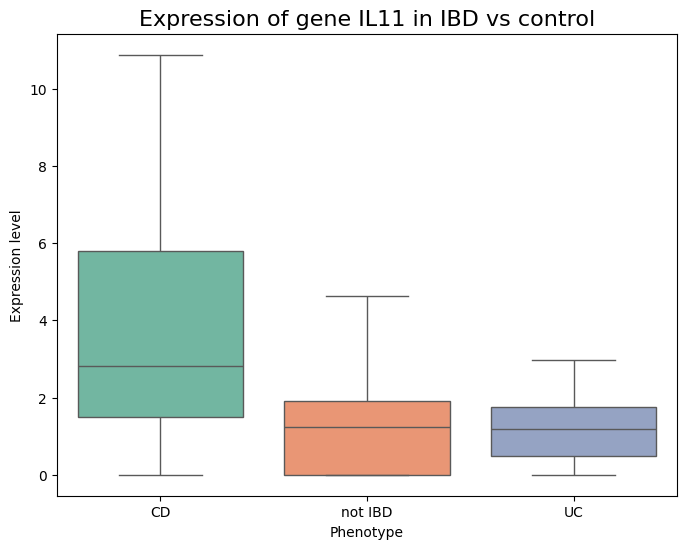

In [6]:
sel_gene = "IL11"

plt.figure(figsize=(8,6))

sns.boxplot(data = joint_data, x="phenotype", y=sel_gene, palette="Set2", legend=False, showfliers=False)
plt.title(f"Expression of gene {sel_gene} in IBD vs control", fontsize=16)
plt.xlabel("Phenotype")
plt.ylabel("Expression level")
plt.show()

Volcano plot for all genes can give a better visualization of the genes that appear statistically significant and have large magnitude of change between two groups.

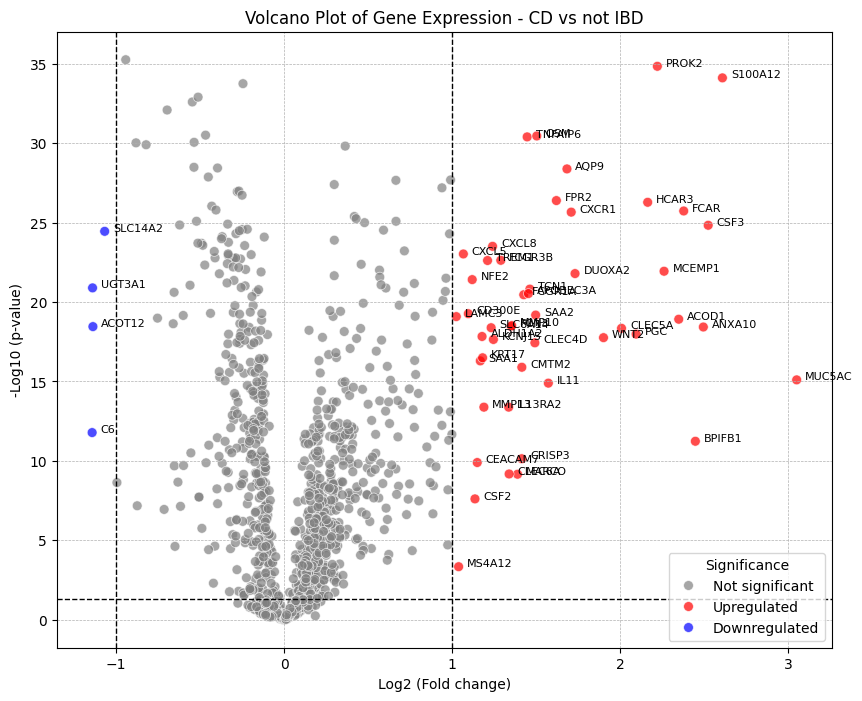

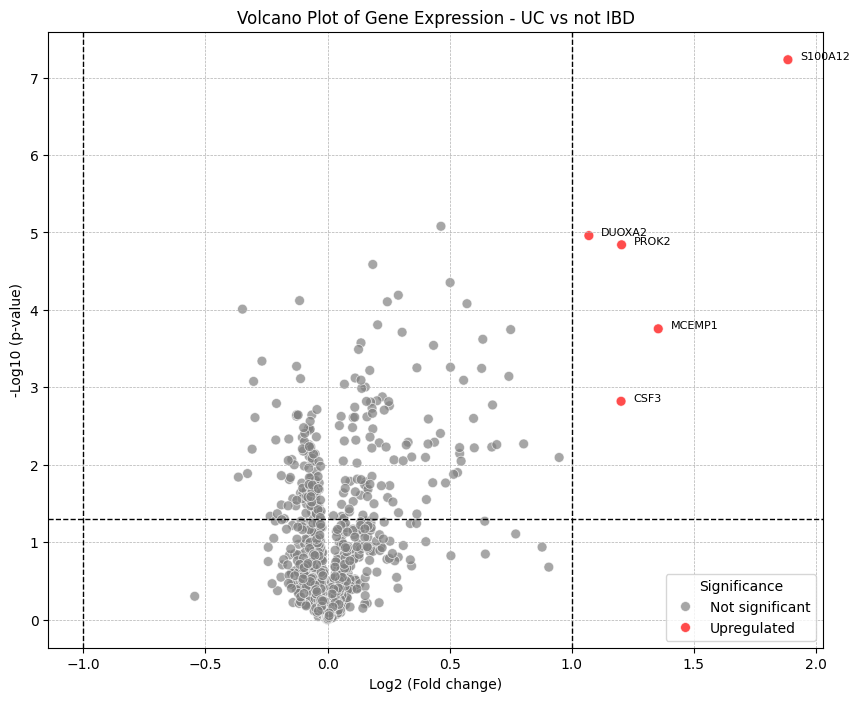

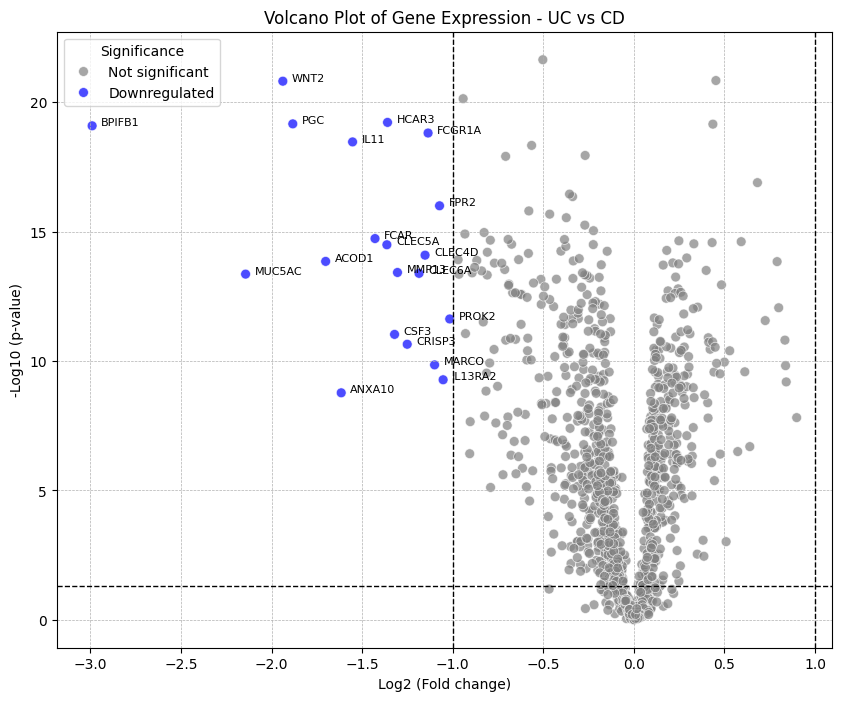

In [7]:
results = []
g_0 = "not IBD"
g_1 = "CD"
g_2 = "UC"
combinations = [[g_0, g_1], [g_0, g_2], [g_1, g_2]]

for groups in combinations:

    g2 = groups[0]
    g1 = groups[1]
    
    group1 = joint_data[joint_data["phenotype"] == g1]
    group2 = joint_data[joint_data["phenotype"] == g2]

    for gene in gene_cols:
        mean_group1 = group1[gene].mean()
        mean_group2 = group2[gene].mean()

        eps = 1e-9
        if mean_group2 < eps: mean_group2 = eps

        log2_fc = np.log2(mean_group1 / mean_group2)

        stat, p_value = ttest_ind(group1[gene], group2[gene], equal_var=False)

        results.append({"gene":gene,
                        "log2_fc":log2_fc,
                        "p_value":p_value})

    results_df = pd.DataFrame(results)
    results_df["-log10_p_value"] = -np.log10(results_df["p_value"])

    p_value_threshold = 0.05
    fc_threshold = 2.0
    results_df["significance"] = "Not significant"
    results_df.loc[(results_df["p_value"] < p_value_threshold) & (results_df["log2_fc"] > np.log2(fc_threshold)), "significance"] = "Upregulated"
    results_df.loc[(results_df["p_value"] < p_value_threshold) & (results_df["log2_fc"] < -np.log2(fc_threshold)), "significance"] = "Downregulated"

    plt.figure(figsize=(10,8))

    sns.scatterplot(
        data = results_df,
        x = "log2_fc",
        y = "-log10_p_value",
        hue = "significance",
        palette = {"Upregulated":"red", "Downregulated":"blue", "Not significant": "grey"},
        s = 50,
        alpha=0.7
    )
    plt.axvline(x=np.log2(fc_threshold), color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-np.log2(fc_threshold), color='black', linestyle='--', linewidth=1)
    plt.axhline(y=-np.log10(p_value_threshold), color='black', linestyle='--', linewidth=1)

    for i, row in results_df.iterrows():
        if row["significance"] != "Not significant":
            plt.text(row["log2_fc"] + 0.05, row["-log10_p_value"], row["gene"], fontsize=8)

    plt.title(f"Volcano Plot of Gene Expression - {g1} vs {g2}")
    plt.xlabel("Log2 (Fold change)")
    plt.ylabel("-Log10 (p-value)")
    plt.legend(title="Significance")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()
    # reset
    results = []